In [43]:
# 1. Thabetelli l'internet ma7loula fil settings 3al limin! (Settings -> Internet On)
# 2. Instali el packages bil esm s7i7:
!pip install -q grad-cam
!pip install -q opencv-python-headless

In [44]:
import os
import zipfile
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Instali Grad-CAM kenou mech mawjoud
try:
    from pytorch_grad_cam import GradCAM
except ImportError:
    !pip install -q pytorch-grad-cam
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image

# --- FAKK EL DHA8T AUTO (AUTO-EXTRACT) ---
# Houni nlawej 3al zip file elli jay mil notebook loula
dataset_zip = None
for root, _, files in os.walk('/kaggle/input'):
    for file in files:
        if file.endswith('.zip') and 'resnet' in file: # Looks for 'dataset_resnet_224.zip'
            dataset_zip = os.path.join(root, file)
            break

WORK_DIR = "/kaggle/working/data"
if dataset_zip and not os.path.exists(WORK_DIR):
    print(f"Extracting {dataset_zip} to {WORK_DIR} (Fast I/O)...")
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall(WORK_DIR)
    DATA_DIR = os.path.join(WORK_DIR, "processed_dataset", "resnet_224") # Adjust based on zip structure
else:
# Ken ma3mlnech zip, wala déjà extractina
    DATA_DIR = "/kaggle/working/processed_dataset/resnet_224" 
    
print(f"Data Source: {DATA_DIR}")

Data Source: /kaggle/working/processed_dataset/resnet_224


In [45]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from collections import Counter
import cv2

# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_EPOCHS = 15 # 15 epochs yzziw 3alle5er lil Transfer Learning
LEARNING_RATE = 1e-4 # Vitesse ta3alom rzina (low LR) bch manfasdouch el pre-training
TARGET_SIZE = 224

print(f"Training on: {DEVICE}")

Training on: cuda


In [30]:
# --- SMART DATA SETUP ---
import os
import zipfile

# 1. the input Zip file
dataset_zip = None
for root, _, files in os.walk('/kaggle/input'):
    for file in files:
        if file.endswith('.zip') and 'resnet' in file:
            dataset_zip = os.path.join(root, file)
            break

# 2. Extracti kenou mech mawjoud
WORK_DIR = "/kaggle/working/data"
if dataset_zip:
    if not os.path.exists(WORK_DIR):
        print(f"Extracting {dataset_zip} to {WORK_DIR}...")
        with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
            zip_ref.extractall(WORK_DIR)
else:
    print(" WARNING: No Zip file found in input. Checking if data exists locally...")

# 3. IMPORTANT: Lawej 3al racine s7i7a mte3 data
# Nlawej 3al dossier elli fih 'train' w 'val' zouz m3a b3adhhom
found_data_dir = None
for root, dirs, files in os.walk(WORK_DIR):
    if 'train' in dirs and 'val' in dirs:
        found_data_dir = root
        break

if found_data_dir:
    DATA_DIR = found_data_dir
    print(f" SUCCESS! Found data at: {DATA_DIR}")
else:
# Ken mal9inech, affichi structure bch nifhmou lghalta win
    print(" ERROR: Could not find a 'train' folder. Here is the folder structure:")
    for root, dirs, _ in os.walk("/kaggle/working"):
        print(f"{root} -> {dirs}")
    raise FileNotFoundError("Could not locate the dataset training folder.")

# 4. Now update your ImageFolder call
# (You don't need to change the next cell, just re-run this one, then the training cell)

✅ SUCCESS! Found data at: /kaggle/working/data/resnet_224


In [50]:
# ---AUGMENTATION ---
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        
       # Geometrics (Tabdil fil chkal)
        transforms.RandomHorizontalFlip(p=0.5),# Miroir
        transforms.RandomRotation(15),     # rotation
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        
# Color/Lighting (Bch el model mayrakkazch barcha 3al dhaw)
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
        # CRITICAL ADDITION: Random Erasing
        # Randomly blacks out a small part of the image. 
        # Forces the model to use context (e.g., eyes) if the mouth is hidden.
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.15)) 
    ]),
    
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Fix the DataLoader Crash
# We use the 'sampler' defined in your previous code
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, sampler=sampler, num_workers=0),
    'val': DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=0),
    'test': DataLoader(image_datasets['test'], batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
}
print("✅ Augmented Data Pipeline Ready (RandomErasing + Num_Workers=0)")

✅ Augmented Data Pipeline Ready (RandomErasing + Num_Workers=0)


In [32]:
# Change num_workers to 0 to fix the "AssertionError" crash
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, sampler=sampler, num_workers=0),
    'val': DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=0),
    'test': DataLoader(image_datasets['test'], batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
}
print("✅ Dataloaders fixed (num_workers=0). Crash should be gone.")

✅ Dataloaders fixed (num_workers=0). Crash should be gone.


In [38]:
# ---MIXUP UTILITIES ---
def mixup_data(x, y, alpha=1.0, use_cuda=True):
'''Traja3 tsawer m5altin, w zouz labels (mte3 taswira A w taswira B), w lambda (el pourcentage)'''    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    # El loss tewallli m5alta: chwaya mil class A w chwaya mil class B
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [39]:
# ---FINE-TUNING MODEL ---
def get_finetuning_model():
    model = models.resnet50(weights='IMAGENET1K_V1')
    
# 1. Abda ijmed (freeze) kol chay f lawel
    for param in model.parameters():
        param.requires_grad = False
        
    # 2. Sayyeb (UNFREEZE) Layer 3 w Layer 4
    # Layer 3: Yet3alem el "Ajze2" (3inin, Fomm)
    # Layer 4: Yet3alem el "Mafahim" (Emotion kamla)
    for name, param in model.named_parameters():
        if "layer3" in name or "layer4" in name:
            param.requires_grad = True
            
# 3. Head Jdid (Rass el model) - Equilibré bin capacité w regularization
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.4),            # Reduced from 0.6 to 0.4
        nn.Linear(num_ftrs, 512),   # Increased capacity back to 512
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    
    return model.to(DEVICE)

model = get_finetuning_model()

# --- DIFFERENTIAL LEARNING RATES (El Sirr lkol houni) ---
# El Corps (ResNet) yet3alem bchwya bchwya (1e-5) bch mayfasadch ro7o
# El Head (Classifier) yet3alem bil zrba (1e-3)
optimizer = optim.AdamW([
    {'params': model.layer3.parameters(), 'lr': 1e-5},  # Body: Slow learning
    {'params': model.layer4.parameters(), 'lr': 1e-5},  # Body: Slow learning
    {'params': model.fc.parameters(), 'lr': 1e-3}       # Head: Fast learning
], weight_decay=0.01) # Reduced weight decay slightly

# Scheduler ytaba3 el learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2)
criterion = nn.CrossEntropyLoss() 

print(" Model Unfrozen (L3+L4) with Differential Learning Rates.")

✅ Model Unfrozen (L3+L4) with Differential Learning Rates.


In [40]:
# --- MIXUP TRAINING LOOP ---
def train_with_mixup(model, num_epochs=15):
    best_f1 = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            
            loop = tqdm(dataloaders[phase], leave=False)
            
            for inputs, labels in loop:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
# --- MIXUP LOGIC (L5alta mte3na) ---
                    if phase == 'train':
                        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels)
                        outputs = model(inputs)
                        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                
                if phase == 'train':
                    # Mixup Accuracy approximation
                    running_corrects += (lam * preds.eq(targets_a.data).cpu().sum().float()
                                       + (1 - lam) * preds.eq(targets_b.data).cpu().sum().float())
                else:
                    running_corrects += torch.sum(preds == labels.data)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

                loop.set_description(f"{phase} Loss: {loss.item():.4f}")

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'val':
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                print(f'  VAL Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | F1: {epoch_f1:.4f}')
                
                history['val_acc'].append(epoch_acc.item())
                
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    torch.save(model.state_dict(), 'best_resnet50_mixup.pth')
                    print("  --> 💾 New Best Model (Mixup) Saved!")
                
                scheduler.step(epoch_f1)
            else:
                print(f'  TRAIN Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} (Approx)')
                history['train_acc'].append(epoch_acc.item())

    return history

history = train_with_mixup(model, num_epochs=NUM_EPOCHS)


Epoch 1/15


  0%|          | 0/85 [00:00<?, ?it/s]

  TRAIN Loss: 2.6094 | Acc: 0.1505 (Approx)


  0%|          | 0/30 [00:00<?, ?it/s]

  VAL Loss: 2.6403 | Acc: 0.0913 | F1: 0.0676
  --> 💾 New Best Model (Mixup) Saved!

Epoch 2/15


  0%|          | 0/85 [00:00<?, ?it/s]

  TRAIN Loss: 2.4350 | Acc: 0.2127 (Approx)


  0%|          | 0/30 [00:00<?, ?it/s]

  VAL Loss: 2.4578 | Acc: 0.1590 | F1: 0.1103
  --> 💾 New Best Model (Mixup) Saved!

Epoch 3/15


  0%|          | 0/85 [00:00<?, ?it/s]

  TRAIN Loss: 2.3639 | Acc: 0.2274 (Approx)


  0%|          | 0/30 [00:00<?, ?it/s]

  VAL Loss: 2.3899 | Acc: 0.1751 | F1: 0.1310
  --> 💾 New Best Model (Mixup) Saved!

Epoch 4/15


  0%|          | 0/85 [00:00<?, ?it/s]

  TRAIN Loss: 2.2690 | Acc: 0.2656 (Approx)


  0%|          | 0/30 [00:00<?, ?it/s]

  VAL Loss: 2.2778 | Acc: 0.1901 | F1: 0.1560
  --> 💾 New Best Model (Mixup) Saved!

Epoch 5/15


  0%|          | 0/85 [00:00<?, ?it/s]

  TRAIN Loss: 2.2114 | Acc: 0.2842 (Approx)


  0%|          | 0/30 [00:00<?, ?it/s]

  VAL Loss: 2.3037 | Acc: 0.1901 | F1: 0.1471

Epoch 6/15


  0%|          | 0/85 [00:00<?, ?it/s]

  TRAIN Loss: 2.1725 | Acc: 0.3109 (Approx)


  0%|          | 0/30 [00:00<?, ?it/s]

  VAL Loss: 2.1260 | Acc: 0.2707 | F1: 0.1839
  --> 💾 New Best Model (Mixup) Saved!

Epoch 7/15


  0%|          | 0/85 [00:00<?, ?it/s]

  TRAIN Loss: 2.1103 | Acc: 0.3255 (Approx)


  0%|          | 0/30 [00:00<?, ?it/s]

  VAL Loss: 2.1870 | Acc: 0.2438 | F1: 0.1810

Epoch 8/15


  0%|          | 0/85 [00:00<?, ?it/s]

  TRAIN Loss: 2.0740 | Acc: 0.3454 (Approx)


  0%|          | 0/30 [00:00<?, ?it/s]

  VAL Loss: 2.0431 | Acc: 0.2943 | F1: 0.2180
  --> 💾 New Best Model (Mixup) Saved!

Epoch 9/15


  0%|          | 0/85 [00:00<?, ?it/s]

  TRAIN Loss: 2.0260 | Acc: 0.3652 (Approx)


  0%|          | 0/30 [00:00<?, ?it/s]

  VAL Loss: 2.1278 | Acc: 0.2342 | F1: 0.1887

Epoch 10/15


  0%|          | 0/85 [00:00<?, ?it/s]

  TRAIN Loss: 2.0290 | Acc: 0.3640 (Approx)


  0%|          | 0/30 [00:00<?, ?it/s]

  VAL Loss: 2.1167 | Acc: 0.2567 | F1: 0.2116

Epoch 11/15


  0%|          | 0/85 [00:00<?, ?it/s]

  TRAIN Loss: 1.9450 | Acc: 0.3987 (Approx)


  0%|          | 0/30 [00:00<?, ?it/s]

  VAL Loss: 2.0404 | Acc: 0.2750 | F1: 0.2241
  --> 💾 New Best Model (Mixup) Saved!

Epoch 12/15


  0%|          | 0/85 [00:00<?, ?it/s]

  TRAIN Loss: 1.9973 | Acc: 0.3787 (Approx)


  0%|          | 0/30 [00:00<?, ?it/s]

  VAL Loss: 1.9756 | Acc: 0.3147 | F1: 0.2302
  --> 💾 New Best Model (Mixup) Saved!

Epoch 13/15


  0%|          | 0/85 [00:00<?, ?it/s]

  TRAIN Loss: 1.8796 | Acc: 0.4249 (Approx)


  0%|          | 0/30 [00:00<?, ?it/s]

  VAL Loss: 2.0295 | Acc: 0.2739 | F1: 0.2112

Epoch 14/15


  0%|          | 0/85 [00:00<?, ?it/s]

  TRAIN Loss: 1.9055 | Acc: 0.4157 (Approx)


  0%|          | 0/30 [00:00<?, ?it/s]

  VAL Loss: 1.9956 | Acc: 0.2846 | F1: 0.2232

Epoch 15/15


  0%|          | 0/85 [00:00<?, ?it/s]

  TRAIN Loss: 1.9014 | Acc: 0.4216 (Approx)


  0%|          | 0/30 [00:00<?, ?it/s]

  VAL Loss: 2.0793 | Acc: 0.2750 | F1: 0.2083


Testing:   0%|          | 0/29 [00:00<?, ?it/s]


Classification Report:
                       precision    recall  f1-score   support

                   11       0.13      0.16      0.14        37
                   12       0.00      0.00      0.00         1
                   13       0.00      0.00      0.00         8
    Angrily_Disgusted       0.22      0.30      0.25        44
    Angrily_Surprised       0.00      0.00      0.00         6
Disgustedly_Surprised       0.57      0.38      0.45       194
      Fearfully_Angry       0.53      0.44      0.48        43
  Fearfully_Surprised       0.43      0.60      0.50       113
    Happily_Disgusted       0.20      0.31      0.25        54
    Happily_Surprised       0.60      0.44      0.50       126
          Sadly_Angry       0.23      0.30      0.26        44
      Sadly_Disgusted       0.56      0.52      0.54       178
        Sadly_Fearful       0.15      0.14      0.14        36
      Sadly_Surprised       0.12      0.20      0.15        25

             accuracy        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


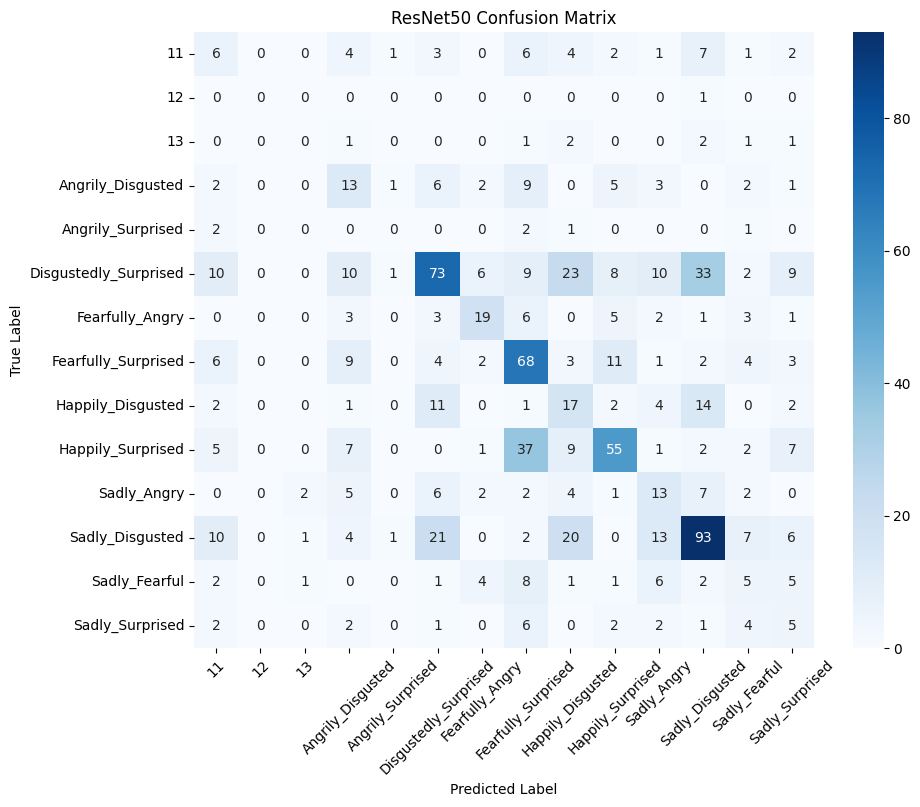

In [46]:
# Load Best Weights
model.load_state_dict(torch.load('best_resnet50.pth'))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in tqdm(dataloaders['test'], desc="Testing"):
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('ResNet50 Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

Visualizing Model Attention (Grad-CAM)...


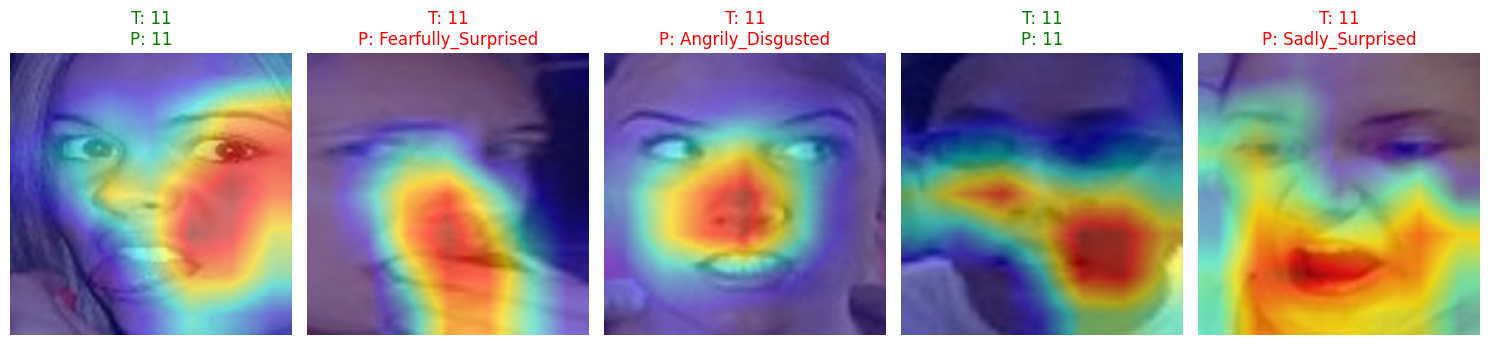

In [48]:

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image # <--- This was missing

def visualize_gradcam_samples(model, num_samples=5):
    model.eval()
    # Layer 4 is the last convolutional block in ResNet
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    
    # Get random test images
    data_iter = iter(dataloaders['test'])
    images, labels = next(data_iter)
    
    images = images[:num_samples].to(DEVICE)
    labels = labels[:num_samples]
    
    # Generate CAM
    grayscale_cam = cam(input_tensor=images, targets=None)
    
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        # Denormalize image for display
        img_tensor = images[i].cpu().permute(1, 2, 0).numpy()
        img_tensor = (img_tensor * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        img_tensor = np.clip(img_tensor, 0, 1)
        
        # Overlay
        visualization = show_cam_on_image(img_tensor, grayscale_cam[i, :], use_rgb=True)
        
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(visualization)
        true_label = class_names[labels[i]]
        
        # Get Model Prediction
        with torch.no_grad():
            out = model(images[i].unsqueeze(0))
            pred_idx = out.argmax().item()
            pred_label = class_names[pred_idx]
            
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"T: {true_label}\nP: {pred_label}", color=color)
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig("gradcam_analysis.png")
    plt.show()

print("Visualizing Model Attention (Grad-CAM)...")
visualize_gradcam_samples(model)